In [1]:
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)
library(dplyr)
library("kknn")
library(ggplot2)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
set.seed(29)
file_path <- "https://github.com/colemantatiana/dsci-100-2023w1-group-29/raw/main/heart.csv"
heart_data <- read_delim(file_path, col_names = TRUE)
heart_data <- mutate(heart_data, target = as.factor(target))
colnames(heart_data)[14] = "diseased"

# Check for missing values
missing <- heart_data |> 
  summarise(across(everything(), ~ sum(is.na(.x))))
missing

# Overview of the data
glimpse(heart_data)
summary(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diseased
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0


Rows: 303
Columns: 14
$ age      <dbl> 63, 37, 41, 56, 57, 57, 56, 44, 52, 57, 54, 48, 49, 64, 58, 5…
$ sex      <dbl> 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1…
$ cp       <dbl> 3, 2, 1, 1, 0, 0, 1, 1, 2, 2, 0, 2, 1, 3, 3, 2, 2, 3, 0, 3, 0…
$ trestbps <dbl> 145, 130, 130, 120, 120, 140, 140, 120, 172, 150, 140, 130, 1…
$ chol     <dbl> 233, 250, 204, 236, 354, 192, 294, 263, 199, 168, 239, 275, 2…
$ fbs      <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0…
$ restecg  <dbl> 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1…
$ thalach  <dbl> 150, 187, 172, 178, 163, 148, 153, 173, 162, 174, 160, 139, 1…
$ exang    <dbl> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0…
$ oldpeak  <dbl> 2.3, 3.5, 1.4, 0.8, 0.6, 0.4, 1.3, 0.0, 0.5, 1.6, 1.2, 0.2, 0…
$ slope    <dbl> 0, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 1…
$ ca       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0…
$ thal     <dbl> 1

      age             sex               cp           trestbps    
 Min.   :29.00   Min.   :0.0000   Min.   :0.000   Min.   : 94.0  
 1st Qu.:47.50   1st Qu.:0.0000   1st Qu.:0.000   1st Qu.:120.0  
 Median :55.00   Median :1.0000   Median :1.000   Median :130.0  
 Mean   :54.37   Mean   :0.6832   Mean   :0.967   Mean   :131.6  
 3rd Qu.:61.00   3rd Qu.:1.0000   3rd Qu.:2.000   3rd Qu.:140.0  
 Max.   :77.00   Max.   :1.0000   Max.   :3.000   Max.   :200.0  
      chol            fbs            restecg          thalach     
 Min.   :126.0   Min.   :0.0000   Min.   :0.0000   Min.   : 71.0  
 1st Qu.:211.0   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:133.5  
 Median :240.0   Median :0.0000   Median :1.0000   Median :153.0  
 Mean   :246.3   Mean   :0.1485   Mean   :0.5281   Mean   :149.6  
 3rd Qu.:274.5   3rd Qu.:0.0000   3rd Qu.:1.0000   3rd Qu.:166.0  
 Max.   :564.0   Max.   :1.0000   Max.   :2.0000   Max.   :202.0  
     exang           oldpeak         slope             ca        
 Mi

In [3]:
# Create training (75%) and testing (25%) data split 
heart_split <- initial_split(heart_data, prop = 0.75, strata = diseased)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

# View training and testing sets
glimpse(heart_train)
glimpse(heart_test)

Rows: 226
Columns: 14
$ age      <dbl> 67, 67, 62, 63, 53, 56, 48, 58, 60, 40, 60, 57, 65, 61, 58, 5…
$ sex      <dbl> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1…
$ cp       <dbl> 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0…
$ trestbps <dbl> 160, 120, 140, 130, 140, 130, 110, 120, 130, 110, 117, 150, 1…
$ chol     <dbl> 286, 229, 268, 254, 203, 256, 229, 284, 206, 167, 230, 276, 2…
$ fbs      <dbl> 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ restecg  <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1…
$ thalach  <dbl> 108, 129, 160, 147, 155, 142, 168, 160, 132, 114, 160, 112, 1…
$ exang    <dbl> 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0…
$ oldpeak  <dbl> 1.5, 2.6, 3.6, 1.4, 3.1, 0.6, 1.0, 1.8, 2.4, 2.0, 1.4, 0.6, 1…
$ slope    <dbl> 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1…
$ ca       <dbl> 3, 2, 2, 1, 0, 1, 0, 0, 2, 0, 2, 1, 3, 0, 1, 0, 1, 1, 0, 3, 1…
$ thal     <dbl> 2

In [4]:
names <- colnames(heart_train |> select(age, trestbps, chol, thalach, oldpeak))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 5, strata = diseased)

n_total <- length(names)
selected <- c()
for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("diseased", "~", paste(preds_new, collapse="+"))
        heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())
        acc <- workflow() |>
          add_recipe(heart_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,diseased ~ thalach,0.6547431
2,diseased ~ thalach+oldpeak,0.7219368
3,diseased ~ thalach+oldpeak+age,0.7256917
4,diseased ~ thalach+oldpeak+age+trestbps,0.7391304
5,diseased ~ thalach+oldpeak+age+trestbps+chol,0.7298419


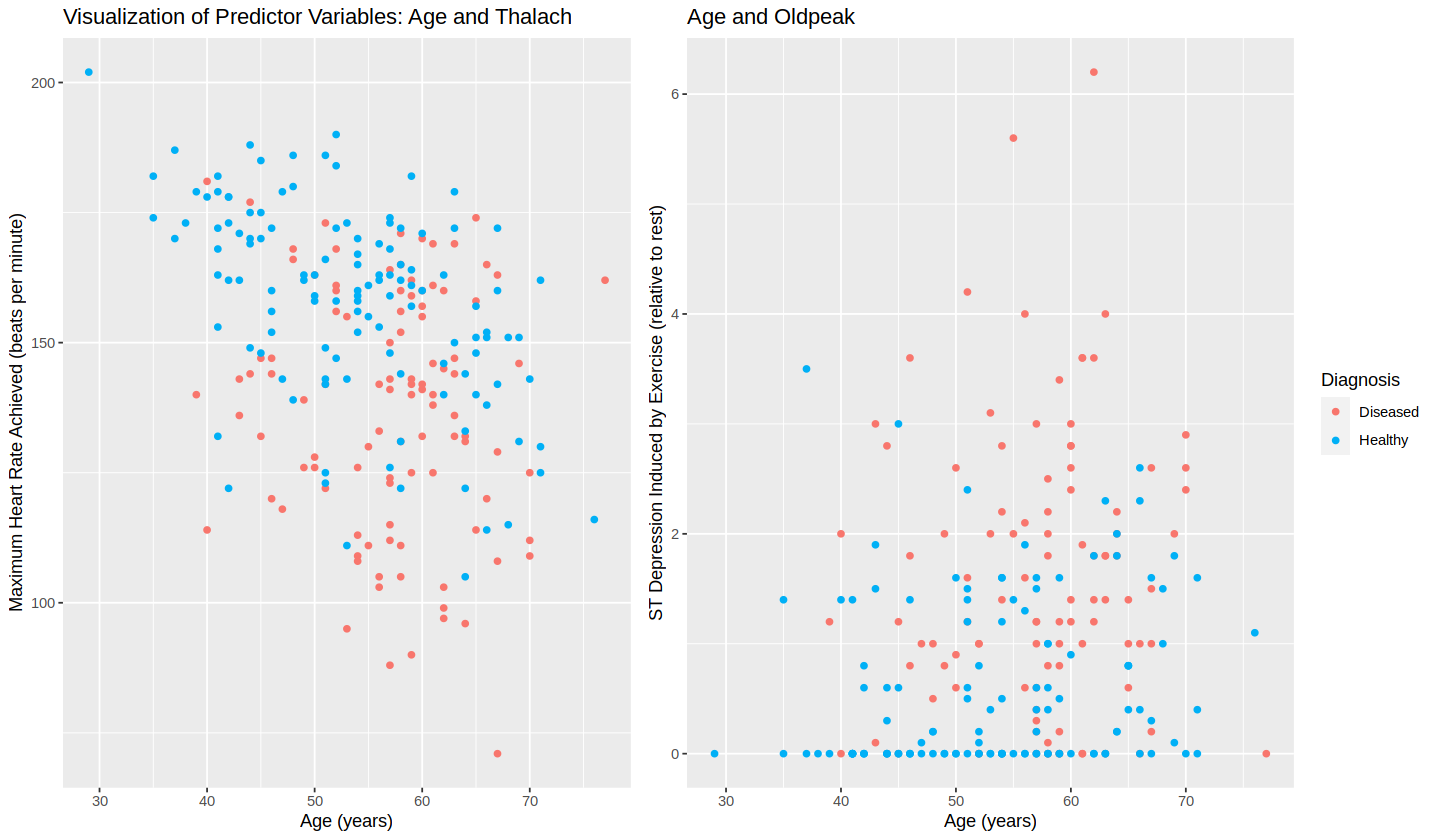

In [23]:
heart_plot1 <- heart_train |>
  ggplot(aes(x = age, 
             y = thalach, 
             colour = diseased)) +
  labs(x = "Age (years)", y = "Maximum Heart Rate Achieved (beats per minute)") +
  theme(legend.position = "none") +
  geom_point() +
  ggtitle("Visualization of Predictor Variables: Age and Thalach") +
  scale_color_manual(values = c("#f8766d", "#00b0f6"))

heart_plot2 <- heart_train |> ggplot(aes(x = age, y = oldpeak, colour = diseased)) + 
    geom_point() + 
    ggtitle("Age and Oldpeak") + 
    labs(x = "Age (years)", y = "ST Depression Induced by Exercise (relative to rest)", colour = "Diagnosis") +
    scale_color_manual(labels = c("Diseased", "Healthy"), values = c("#f8766d", "#00b0f6"))

options(repr.plot.height = 7, repr.plot.width = 12)
heart_plots <- plot_grid(heart_plot1, heart_plot2,
                         ncol = 2, nrow = 1, 
                         rel_widths = c(4,5))
heart_plots